In [55]:
%matplotlib inline
import glob
import os

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mpc
import matplotlib.gridspec as mgrid
import matplotlib.tri as tri

import h5py
from umap import UMAP
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from scipy.stats import entropy

from activ.clustering.summarize import read_clustering_results, summarize_flattened, plot_line 
from activ.clustering.clustering import flatten
from activ.readfile import TrackTBIFile

from activ.clustering.summarize import read_clustering_results, summarize_flattened, plot_line, flatten_summarize
from activ.clustering.clustering import get_noc, get_noc_max1d_smooth

In [5]:
TRACK_TBIFILE_PATH = '../tracktbi_files/tracktbi.scalar.h5'

In [12]:
tbifile = TrackTBIFile(TRACK_TBIFILE_PATH)
emb = UMAP(n_components=2, min_dist=0, random_state=20001).fit_transform(tbifile.outcomes)
dist = pdist(emb)
Z = linkage(dist, method='ward')
labels = cut_tree(Z, n_clusters=np.arange(2,51))

In [28]:
def avg_entropy(variable, labels):
    values = list()
    weights = list()
    for l in np.unique(labels):
        mask = labels == l
        subset = variable[mask]
        uniq, counts = np.unique(subset, return_counts=True)
        values.append(entropy(counts / counts.sum()))
        weights.append(mask.sum())
    return np.inner(values, weights)/len(labels)

def entropy_across_clusterings(variable, labels):
    ret = list()
    for clust_i in range(labels.shape[1]):    
        ret.append(avg_entropy(variable, labels[:, clust_i]))
    return np.array(ret)

In [56]:
x = np.arange(2, 51)
init = list()
y = list()
for var_i in range(tbifile.outcomes.shape[1]):
    y.append(entropy_across_clusterings(tbifile.outcomes[:, var_i], labels))
    init.append(y[-1][0])
init = np.array(init)# / np.max(init)    
y = np.array(y)

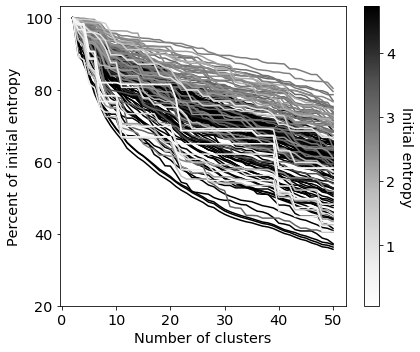

In [89]:
plt.figure(figsize=(6, 5))
ax = plt.gca()
cmap = cm.get_cmap("Greys")
order = np.argsort(init)[::-1]
for var_i in order:
    ax.plot(x, y[var_i]/init[var_i], c=cmap(init[var_i]))
ax.set_ylabel("Percent of initial entropy", fontsize='x-large')
ax.set_xlabel("Number of clusters", fontsize='x-large')

yticks = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_yticks(yticks)
ax.set_yticklabels((yticks*100).astype(int), fontsize='x-large')

xticks = np.arange(6)*10
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize='x-large')

cbar = ax.figure.colorbar(cm.ScalarMappable(norm=mpc.Normalize(vmin=np.min(init), vmax=np.max(init)), cmap=cmap), ax=ax)
cbar.set_label("Initial entropy", rotation=-90, va="bottom", fontsize='x-large')
cbar_yticks = [1, 2, 3, 4]

cbar.ax.set_yticklabels(cbar_yticks, fontsize='x-large')
plt.tight_layout()
plt.savefig("../paper/entropy.png", dpi=200)